<a href="https://colab.research.google.com/github/Escandonn/Ia-Clasificacion-img/blob/main/_clasificaci_n_de_flores_efficientnetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurar TensorFlow 2.x:
### Asegúrate de que Colab esté usando TensorFlow 2.x ejecutando la siguiente celda al principio de tu notebook:

In [1]:
%tensorflow_version 2.x


Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


# importar Bibliotecas Necesarias:
### Importa las bibliotecas necesarias, incluyendo TensorFlow, TensorFlow Hub y otras utilidades estándar de Python:

In [2]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import numpy as np


#Selección del Modelo y Configuración
### Selección del Modelo: Vamos a utilizar EfficientNetV2 desde TensorFlow Hub para la clasificación de imágenes. Puedes elegir diferentes variantes del modelo según tus necesidades:

In [3]:
model_name = "efficientnetv2-xl-21k"
model_handle_map = {
    "efficientnetv2-xl-21k": "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
}
model_handle = model_handle_map.get(model_name)


# Tamaño de Imagen:
### Define el tamaño de imagen que el modelo espera como entrada. Este tamaño puede variar según el modelo seleccionado:

In [4]:
IMAGE_SIZE = (512, 512)  # Tamaño de imagen para el modelo seleccionado


#Preparación de los Datos
### Descargar y Preparar el Conjunto de Datos: Utilizaremos un conjunto de datos de ejemplo de flores para este tutorial. El siguiente código descargará y preparará el conjunto de datos automáticamente:

In [5]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)


228813984/228813984 [==============================] - 12s 0us/step


#Configuración de Generadores de Datos:
### Configura generadores de datos para entrenamiento y validación utilizando tf.keras.preprocessing.image.ImageDataGenerator. Asegúrate de ajustar los parámetros según tus necesidades, como el tamaño de imagen y el tamaño del lote:

In [6]:
datagen_kwargs = dict(rescale=1./255, validation_split=.20)
dataflow_kwargs = dict(target_size=IMAGE_SIZE, batch_size=32, interpolation="bilinear")

datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)

train_generator = datagen.flow_from_directory(
    data_dir, subset="training", shuffle=True, **dataflow_kwargs)

val_generator = valid_datagen.flow_from_directory(
    data_dir, subset="validation", shuffle=False, **dataflow_kwargs)


Found 2939 images belonging to 5 classes.
Found 731 images belonging to 5 classes.


#Construcción y Compilación del Modelo
### Construcción del Modelo: Utiliza TensorFlow Hub para crear un modelo secuencial que incluya el modelo EfficientNetV2 como una capa Keras:

In [7]:
do_fine_tuning = False  # Ajuste fino del modelo

print("Building model with", model_handle)
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=IMAGE_SIZE + (3,)),
    hub.KerasLayer(model_handle, trainable=do_fine_tuning),
    tf.keras.layers.Dropout(rate=0.2),
    tf.keras.layers.Dense(train_generator.num_classes, activation='softmax')
])


Building model with https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2


#Compilación del Modelo:
### Compila el modelo especificando el optimizador, la función de pérdida y las métricas:

In [8]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=0.1),
    metrics=['accuracy'])


# Entrenamiento y Evaluación del Modelo
### Entrenamiento del Modelo: Entrena el modelo utilizando el generador de datos de entrenamiento y especificando el número de épocas:

In [9]:
epochs = 5

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator)


Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5575: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


92/92 [==============================] - 349s 3s/step - loss: 0.8138 - accuracy: 0.8527 - val_loss: 0.5529 - val_accuracy: 0.9590
Epoch 2/5
92/92 [==============================] - 289s 3s/step - loss: 0.5664 - accuracy: 0.9578 - val_loss: 0.5423 - val_accuracy: 0.9508
Epoch 3/5
92/92 [==============================] - 289s 3s/step - loss: 0.5250 - accuracy: 0.9731 - val_loss: 0.5143 - val_accuracy: 0.9617
Epoch 4/5
92/92 [==============================] - 289s 3s/step - loss: 0.5046 - accuracy: 0.9758 - val_loss: 0.5070 - val_accuracy: 0.9631
Epoch 5/5
92/92 [==============================] - 290s 3s/step - loss: 0.4855 - accuracy: 0.9833 - val_loss: 0.4984 - val_accuracy: 0.9631


#Evaluación del Modelo:
### Evalúa el modelo en el conjunto de validación para obtener la precisión final:

In [10]:
loss, accuracy = model.evaluate(val_generator)
print(f'Validation accuracy: {accuracy:.2f}')


23/23 [==============================] - 58s 3s/step - loss: 0.4984 - accuracy: 0.9631
Validation accuracy: 0.96


#Visualización de Resultados
### Visualización de Métricas de Entrenamiento: Grafica la precisión y la pérdida durante el entrenamiento y validación para evaluar el rendimiento del modelo:

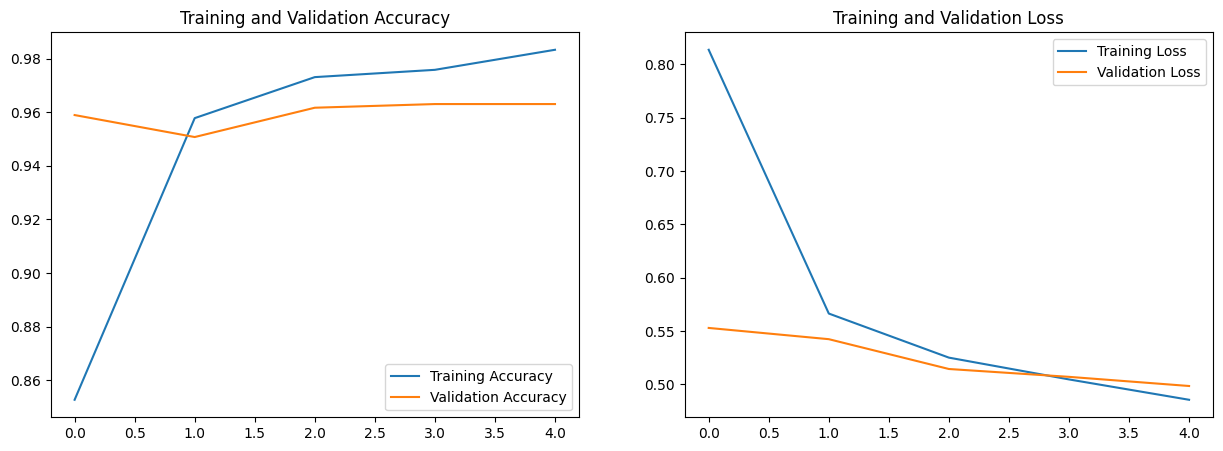

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
